In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os, sys
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import h5py
import quantities as pq

sys.path.append('../scripts/')
sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

In [3]:
sim_data_dir = '../data/sim_data/'
fig_dir = 'Figures/test_notebooks'

In [4]:
# for plotting
plt.rcParams.update({'font.size': 16})

flash_types = ['white', 'black']

In [5]:
t_rem_trial_start = 50
nstim = 2
ntime = 700
trial_dur_sim = 750

## Load Data

In [6]:
include_lgn = True
npop_guess = 1

pop_names = []
if include_lgn:
    pop_names.append('LGN')

if npop_guess == 4:
    pop_names.append('L2/3')
    pop_names.append('L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 3:
    pop_names.append('L2/3 and L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 2:
    pop_names.append('Upper layers')
    pop_names.append('Deep layers')
elif npop_guess == 1:
    pop_names.append('V1')
    
pop_names.append('FB')
pop_names.append('BKG')

## Load pre-synaptic firing rates used in decomposition

In [7]:
timestamps_all_stim = dict()

In [8]:
selected_sims_data_dir = os.path.join(sim_data_dir, '*full_model*')
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir.rsplit('/', 1)[0], 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['full_model_white_flash', 'full_model_black_flash']


#### Compute population firing rates

In [9]:
npop_guess = 1

In [10]:
sims_spike_trains_cell_pops = timestamps_to_spiketrains_sim(timestamps_configs, mode = 'only_exc')


 full_model_white_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a
Use only excitatory cells. Skip.
i5Pvalb
Use only excitatory cells. Skip.
i5Sst
Use only excitatory cells. Skip.
i6Htr3a
Use only excitatory cells. Skip.
i6Pvalb
Use only excitatory cells. Skip.
i6Sst
Use only excitatory cells. Skip.

 full_model_black_flash
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a


In [11]:
sims_spike_trains_layer_pops = spiketrains_by_layer(sims_spike_trains_cell_pops, npop_guess = npop_guess)

full_model_white_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
full_model_black_flash
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882


In [12]:
fir_rate_all_trials = dict()
fir_rate_trial_avg = dict()

fir_rate_trial_avg_pops_temp = np.zeros((len(sims_spike_trains_layer_pops.keys()), npop_guess, 700))
for isim, sim_name in enumerate(sims_spike_trains_layer_pops.keys()):
    print(sim_name)
    for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
        print(pop_name)
        fir_rate_temp = np.mean(np.mean(sims_spike_trains_layer_pops[sim_name]\
                                            [pop_name][:,:,t_rem_trial_start:], axis = 0), axis = 0)
        
        fir_rate_trial_avg_pops_temp[isim, ipop] = fir_rate_temp
        

for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
    print(pop_name)
    fir_rate_trial_avg[pop_name] = fir_rate_trial_avg_pops_temp[:, ipop]

full_model_white_flash
v1
full_model_black_flash
v1
v1


### Load LGN input

In [13]:
fir_rate_lgn_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [14]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'lgn_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

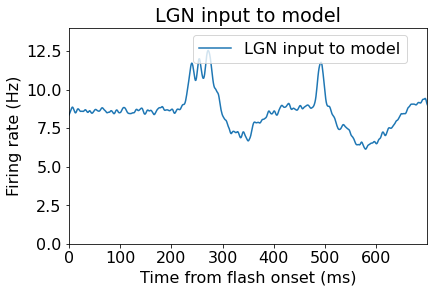

In [15]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_w_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_lgn_flash_plot = np.mean(fir_rate_lgn_input_w_flash, axis=0)
istim = 0
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_flash_plot
fir_rate_lgn_flash_plot = gaussian_filter1d(fir_rate_lgn_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Black flash

In [16]:
filename = 'lgn_black_flash_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

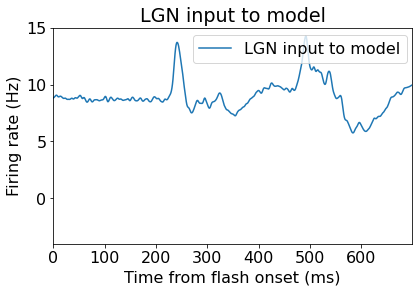

In [17]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_b_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_b_flash = (fir_rate_lgn_input_b_flash.T - np.mean(fir_rate_lgn_input_b_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,tstim_onset_sim:]
fir_rate_lgn_b_flash_plot = np.mean(fir_rate_lgn_input_b_flash, axis=0)
istim = 1
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_b_flash_plot
fir_rate_lgn_b_flash_plot = gaussian_filter1d(fir_rate_lgn_b_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_b_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([-4, 15])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Load FB input

In [18]:
fir_rate_fb_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [19]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'fb_from_LM_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

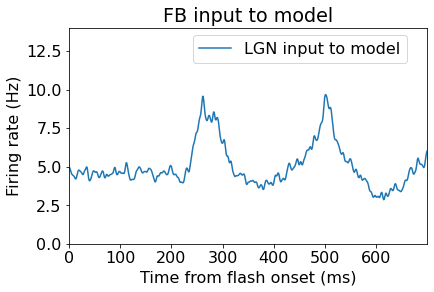

In [20]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 0
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

#### Black flash

In [21]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'fb_from_LM_black_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

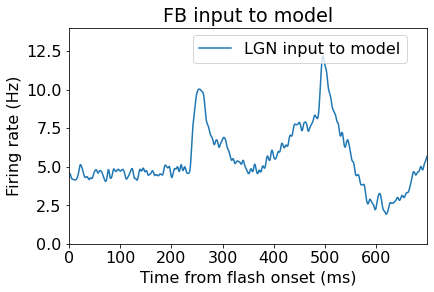

In [22]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 1
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Background input

In [23]:
fir_rate_bkg_all_stim_trial_avg = np.zeros((nstim, ntime))

In [24]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'bkg_nest.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_bkg_input = np.array(file['spikes']['gids'])
timestamps_bkg_input = np.array(file['spikes']['timestamps'])
file.close()

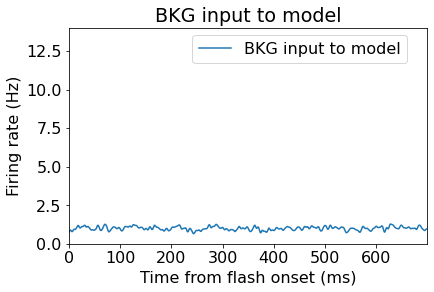

In [25]:
ntrials_sim = 10
bins_bkg = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_bkg_input_w_flash = np.histogram(timestamps_bkg_input, bins = bins_bkg)[0]/1E3
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_bkg_flash_plot = np.mean(fir_rate_bkg_input_w_flash, axis=0)
for istim in range(2):
    fir_rate_bkg_all_stim_trial_avg[istim] = fir_rate_bkg_flash_plot

fir_rate_bkg_flash_plot = gaussian_filter1d(fir_rate_bkg_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_bkg_flash_plot*1E3, color = 'tab:blue', label = 'BKG input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('BKG input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'BKG-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Put all model pre-synaptic firing rates together

In [26]:
rmat_model = np.zeros((nstim, fir_rate_lgn_all_stim_trial_avg.shape[1], npop_guess+3))
rmat_model[:, :, 0] = fir_rate_lgn_all_stim_trial_avg

for ipop, pop_name in enumerate(fir_rate_trial_avg.keys()):
    rmat_model[:, :, 1+ipop] = fir_rate_trial_avg[pop_name]
    
rmat_model[:, :, -2] = fir_rate_fb_all_stim_trial_avg
rmat_model[:, :, -1] = fir_rate_bkg_all_stim_trial_avg

## Load LPA-estimated temporal profiles of pre-synaptic V1 firing rate and plot (see supplementary figure S5)

In [32]:
filename = 'lpa_on_sim_mua_1pops.npy'

loadpath = os.path.join('lpa_results_data', filename)

data_lpa_mua = np.load(loadpath, allow_pickle=True)[()]

In [33]:
fir_rate_lpa_est = data_lpa_mua['rmat']

In [34]:
fir_rate_lpa_est.shape

(2, 700, 1)

In [35]:
rmat_w_lpa_est = np.zeros((nstim, fir_rate_lgn_all_stim_trial_avg.shape[1], npop_guess+3))
rmat_w_lpa_est[:, :, 0] = fir_rate_lgn_all_stim_trial_avg

rmat_w_lpa_est[:, :, 1] = fir_rate_lpa_est[:,:,0]
    
rmat_w_lpa_est[:, :, -2] = fir_rate_fb_all_stim_trial_avg
rmat_w_lpa_est[:, :, -1] = fir_rate_bkg_all_stim_trial_avg

In [27]:
subtract_baseline = True
tstim_onset_sim = 200

NameError: name 'rmat_w_lpa_est' is not defined

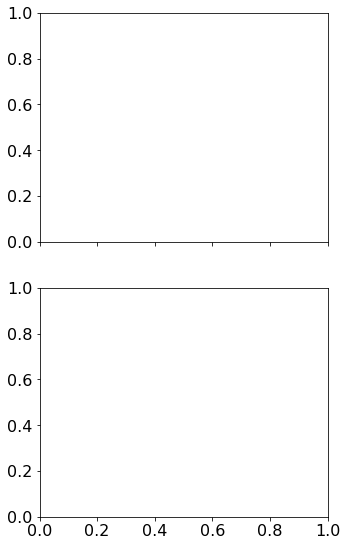

In [28]:
fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (8,5*2), sharex = True, sharey = True)

fig.subplots_adjust(left = 0.15, right = 0.65, bottom = 0.15, top = 0.85)

#t = np.arange(ntime)
#channel = np.arange(nchan)

colors = ['lime', 'black', 'r', 'm']
    
'''if Rmat_lpa.shape[-1] == 6:
    colors = ['lime', 'b', 'g', 'r', 'm', 'pink' ]
    pop_names = np.concatenate([pop_names, pop_names])'''
    
for istim in range(2):
    ax = axes[istim]
    for ipop in range(rmat_w_lpa_est.shape[-1]):
        fir_rate_lpa_plot = rmat_w_lpa_est[istim,:,ipop]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
        if ~subtract_baseline:
            fir_rate_lpa_plot -= np.mean(fir_rate_lpa_plot[100:tstim_onset_sim], axis = 0)
        if ipop != 1:
            fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 2)/gaussian_filter(rmat_w_lpa_est, sigma = (0,2,0)).max()
        else:
            fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 2)/gaussian_filter(rmat_w_lpa_est[:,:,1], sigma = (0,2)).max()
        ax.plot(fir_rate_lpa_plot, color = colors[ipop], label=pop_names[ipop])
        #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
        if istim == 1:
            ax.set_xlabel('Time from stimulus onset (ms)')
        ax.set_ylabel('Magnitude (normalized)')
        #ax[1,0].set_ylabel('Magnitude (a. u.)')

        #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
        ax.set_title(flash_types[istim].capitalize()+' flash')

    ax.set_xticks(np.arange(0,fir_rate_lpa_plot.shape[0],200))
    ax.set_xticklabels(np.arange(0,fir_rate_lpa_plot.shape[0],200)-200)

    ax.margins(x=0)
    
fig.suptitle('Temporal profiles of firing rates in pre-synaptic\npopulations, V1 estimated with LPA', x = 0.41, y = 0.95)
    
ax.legend(bbox_to_anchor = (1,0.8))

#fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)

#fig_name = 'pre-synaptic-firing-rates-V1-merged.png'

fig_name = 'pre-synaptic-firing-rates-V1-merged-w-lpa-est-fir-rates.png'

savepath = os.path.join(fig_dir, 'pre_syn_temporal_profiles')
                        
if not os.path.exists(savepath):
        os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
                        
#fig.savefig(savepath, facecolor = 'w')

## Load LFP from simulations

In [29]:
lfp_sims_all_stim = dict()

In [30]:
selected_sims_data_dir = os.path.join(sim_data_dir, '*full_model*')

lfp_sims = find_files(selected_sims_data_dir, filename = 'lfp_w_baseline.npy')

sim_names = list(lfp_sims.keys())

print(sim_names)
    
for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim_temp = dict()
    lfp_sims_all_stim_temp['all_trials'] = lfp_sims[sim_name]['all_trials']#[:,:,tstim_onset_sim:]
    lfp_sims_all_stim_temp['trial_avg'] = lfp_sims[sim_name]['trial_avg']#[:,tstim_onset_sim:]
    lfp_sims_all_stim[sim_name] = lfp_sims_all_stim_temp

['full_model_white_flash', 'full_model_black_flash']


### Compute CSD

In [31]:
nchan_lim = 22
tstim_onset_sim = 200

In [32]:
method='DeltaiCSD'

#csd_for_lpa = np.zeros((nstim, nchan_lim, ntime))

csd_sims = dict()
for isim, sim_name in enumerate(lfp_sims_all_stim.keys()):
    print(sim_name)
    lfp_temp = lfp_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]
    
    csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                        coord_electrodes = np.linspace(0,840E-6, lfp_temp.shape[0]) * pq.m)
    
    csd_sims[sim_name] = csd_temp

full_model_white_flash
full_model_black_flash


## Load LPA results data

In [116]:
subtract_baseline = True
baseline_presubtracted_lfp = False
if subtract_baseline:
    baseline_end = 200
    baseline_string = 'baseline_subtracted'
else:
    baseline_end = 0
    if baseline_presubtracted_lfp:
        baseline_string = 'baseline_pre_subtracted'
        baseline_end_fir_rates = 250
    else:
        baseline_string = 'w_baseline'

In [119]:
lpa_results_data_dir = 'lpa_results_data'

filename = 'LPA_on_sim_CSD_narrow_range_of_pen_facs.npy'

loadpath = os.path.join(lpa_results_data_dir, filename)

In [121]:
data_lpa = np.load(loadpath, allow_pickle = True)[()]

In [122]:
Cphi_lpa = data_lpa['Cphi']
Rmat = data_lpa['Rmat']
Cmat = data_lpa['Cmat']
error = data_lpa['error_wo_pen']
kernels = data_lpa['kernels']
taus = data_lpa['tau']
deltas = data_lpa['delta']
pen_facs = data_lpa['penalty_factor']

In [123]:
pen_facs

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

In [124]:
sel_pen_fac = pen_facs[0]
sel_pen_fac

0.0

### Deviation from 0 as function of penalty

In [125]:
avg_dev_from_0_lpa_norm = dict()
for pen_fac in list(Cphi_lpa.keys()):
    #print(np.abs(Cphi_lpa[pen_fac].sum(axis=-1)).mean()/np.abs(Cphi_lpa[pen_fac]).max())
    
    avg_dev_from_0_lpa_norm[pen_fac] = np.abs(Cphi_lpa[pen_fac].sum(axis=-1)).mean()/np.abs(Cphi_lpa[pen_fac]).max()

In [126]:
avg_dev_from_0_lpa_norm

{0.0: 0.08161859886323118,
 0.5: 0.06095889112826703,
 1.0: 0.0545752028502889,
 1.5: 0.05637330593695511,
 2.0: 0.050005287891807776,
 2.5: 0.05416849389286077,
 3.0: 0.04737177221263133,
 3.5: 0.047491355281323824,
 4.0: 0.04519335219429507,
 4.5: 0.047040780087736586,
 5.0: 0.047463234839345725,
 5.5: 0.047463234839345725,
 6.0: 0.04838006420551364,
 6.5: 0.04990579585497794,
 7.0: 0.046418721254251345,
 7.5: 0.050861267634537334,
 8.0: 0.050861267634537334,
 8.5: 0.0527112784184968,
 9.0: 0.0527112784184968,
 9.5: 0.0527112784184968}

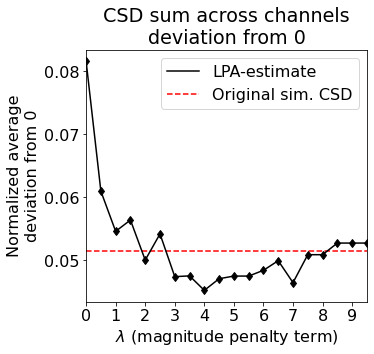

In [127]:
fig, ax = plt.subplots(figsize = (6,5))

pen_values = np.array(list(avg_dev_from_0_lpa_norm.keys()))

ax.plot(pen_values, np.array(list(avg_dev_from_0_lpa_norm.values())), color = 'black', label = 'LPA-estimate')
ax.plot(pen_values, np.array(list(avg_dev_from_0_lpa_norm.values())), 'd', color = 'black')

ax.set_xticks(np.arange(0,10,1))
ax.set_xticks(np.arange(0,10,1))

#ax.set_xscale('log')
ax.set_xlabel('$\lambda$ (magnitude penalty term)')
ax.set_ylabel('Normalized average\ndeviation from 0')

csd_sims_arr = np.array(list(csd_sims.values()))
csd_sims_dev_from_0 = (csd_sims_arr.sum(axis = 1)).mean()/np.abs(csd_sims_arr).max()

ax.hlines(xmin = pen_values[0], xmax = pen_values[-1], y = csd_sims_dev_from_0, color = 'r', \
          ls = '--', label = 'Original sim. CSD')

ax.margins(x=0)

ax.legend()

ax.set_title('CSD sum across channels\ndeviation from 0')

fig.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.15, top = 0.85)

fig_name = 'deviation_from_0_dependence_on_penalty_term.png'

#fig_name = 'deviation_from_0_dependence_on_penalty_term_w_lpa_est_fir_rates.png'

#fig_name = 'deviation_from_0_dependence_on_penalty_term_w_lpa_est_fir_rates_w_rescale.png'

savepath = os.path.join(fig_dir, 'deviation_from_0')

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)
                
savepath = os.path.join(savepath, fig_name)
    
#fig.savefig(savepath, facecolor = 'w')

In [128]:
optimal_pen_fac = pen_facs[np.argmin(np.array(list(avg_dev_from_0_lpa_norm.values())))]

In [129]:
optimal_pen_fac

4.0

## Load ground truth data

In [130]:
config_name = '2022_jan_07_config'

In [131]:
csd_gt_flashes = dict()

for istim in range(2):
    flash_type = flash_types[istim]
    if istim == 0:
        dir_add = ''
        filename_add = ''
    elif istim == 1:
        dir_add = 'black_flash'
        filename_add = '_black'
        

    # LGN
    filename = 'csd_total_lgn.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt = np.load(loadpath, allow_pickle=True)[()]

    # FB
    filename = 'csd_total_fb.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # BKG
    filename = 'csd_total_bkg.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # V1    
    filename = 'csd_total.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # Gather

    csd_gt_sum_v1_all_trials_temp = np.zeros_like(csd_sims_gt[sim_name]['all_trials'])
    csd_gt_sum_v1_trial_avg_temp = np.zeros_like(csd_sims_gt[sim_name]['trial_avg'])
    for sim_name in csd_sims_gt.keys():
        if 'LGN' not in sim_name and '2022_jan_07_fb_only_no_bkg' not in sim_name:
            csd_gt_sum_v1_all_trials_temp += csd_sims_gt[sim_name]['all_trials']
            csd_gt_sum_v1_trial_avg_temp += csd_sims_gt[sim_name]['trial_avg']

    csd_sims_gt_sum_v1_temp = dict()
    csd_sims_gt_sum_v1_temp['all_trials'] = csd_gt_sum_v1_all_trials_temp
    csd_sims_gt_sum_v1_temp['trial_avg'] = csd_gt_sum_v1_trial_avg_temp

    csd_sims_gt_v1_summed = dict()
    if istim == 1:
        csd_sims_gt_v1_summed['LGN'] = csd_sims_gt['all_active_no_recurr_only_LGN_black']
    else:
        csd_sims_gt_v1_summed['LGN'] = csd_sims_gt['2021_dec_16_all_active_only_LGN_w_cut'+filename_add]
    csd_sims_gt_v1_summed['V1'] = csd_sims_gt_sum_v1_temp
    csd_sims_gt_v1_summed['FB'] = csd_sims_gt['2022_jan_07_fb_only_no_bkg'+filename_add]
    csd_sims_gt_v1_summed['BKG'] = csd_sims_gt['2022_jan_07_bkg_only']
    
    csd_gt_flashes[flash_type] = csd_sims_gt_v1_summed

### Compare CSD whole trials

In [132]:
ytick_step = 5
yticks = np.arange(0,26,ytick_step)
ylabel_start = 0
ylabel_stop = 1000
ytick_label_step = int((ylabel_stop-ylabel_start)/ytick_step)
ytick_labels = -np.arange(ylabel_start, ylabel_stop+ytick_label_step, ytick_label_step)

### Evaluate total CSD estimate

In [133]:
optimal_pen_fac

4.0

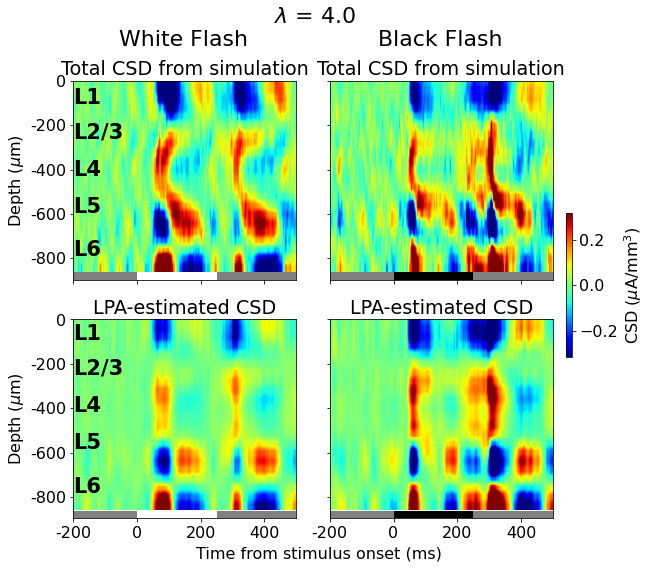

In [136]:
csd_total_rel_MSE_pen = dict()
csd_total_corr_pen = dict()

tstim_onset = 200

for pen_fac in list(Cphi_lpa.keys()):
    
    if pen_fac == optimal_pen_fac:
        fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (9, 8), sharex = True, sharey = True)

    scale_to_uA = 1E-3

    csd_total_rel_MSE = dict()
    csd_total_corr = dict()

    for istim, sim_name, flash_type in zip(range(2), sim_names, ['white', 'black']):
        if pen_fac == optimal_pen_fac:
            ax = axes[0,istim]

        csd_orig_plot = csd_sims[sim_name]
        csd_orig_plot = (csd_orig_plot.T-np.mean(csd_orig_plot[:,:tstim_onset_sim], axis = 1)).T
        csd_orig_plot = csd_orig_plot*scale_to_uA
        cmap_range = np.abs(csd_orig_plot).max()/3
        if pen_fac == optimal_pen_fac:
            ax.imshow(csd_orig_plot, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)
            
        if istim == 0:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
        elif istim == 1:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')

        if pen_fac == optimal_pen_fac:
            if istim == 0:
                ax.set_ylabel('Depth ($\mu$m)')
            ax.set_yticks(np.arange(0,25+5,5))
            ax.set_yticklabels(-np.arange(0,1000+200,200))

            ax.set_title('Total CSD from simulation')

            ax = axes[1,istim]
        #csd_lpa_plot = (Cphi_lpa[isim].T)#.T-np.mean(csd_lpa[:,:tstim_onset_sim], axis = 1)).T
        csd_lpa_plot = (Cphi_lpa[pen_fac][istim]-np.mean(Cphi_lpa[pen_fac][istim,:tstim_onset_sim], axis = 0)).T
        csd_lpa_plot = csd_lpa_plot*scale_to_uA

        #cmap_range = np.abs(MUA_synth).max()/2
        if pen_fac == optimal_pen_fac:
            im = ax.imshow(csd_lpa_plot, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

        diff = csd_lpa_plot-csd_orig_plot.magnitude
        rel_MSE = np.sum(diff**2)/np.sum(csd_orig_plot.magnitude**2)
        corr = np.corrcoef(csd_orig_plot.flatten(), csd_lpa_plot.flatten())[0,1]

        csd_total_rel_MSE[flash_type] = rel_MSE
        csd_total_corr[flash_type] = corr

        if pen_fac == optimal_pen_fac:
            ax.set_title('LPA-estimated CSD')

        if pen_fac == optimal_pen_fac:
            if istim == 0:
                ax.set_ylabel('Depth ($\mu$m)')
                
        if istim == 0:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
        elif istim == 1:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
            
        ax.set_ylim([22.4, 0])

        ax.set_xlim([0, 700])
    if pen_fac == optimal_pen_fac:
        ax.set_xticks(np.arange(0,csd_lpa_plot.shape[1],200))
        ax.set_xticklabels(np.arange(0,csd_lpa_plot.shape[1],200)-200)

        plt.figtext(s = 'Time from stimulus onset (ms)', y = 0.02, x = 0.3)

        plt.figtext(s = 'White Flash', y = 0.91, x = 0.18, fontsize = 22)
        plt.figtext(s = 'Black Flash', y = 0.91, x = 0.58, fontsize = 22)

        plt.figtext(s = '$\lambda$ = '+str(np.round(pen_fac, 2)), y = 0.95, x = 0.42, fontsize = 22)

        cbaxes = fig.add_axes([0.87,0.37,0.01, 0.25])
        cb = fig.colorbar(im, ax = ax, cax = cbaxes)
        cb.set_label('CSD ($\mu$A/mm$^3$)')

        for i in range(2):
            plt.figtext(x = 0.11, y = 0.81-i*0.41, s = 'L1', fontsize = 21, fontweight = 560)
            plt.figtext(x = 0.11, y = 0.75-i*0.41, s = 'L2/3', fontsize = 21, fontweight = 560)
            plt.figtext(x = 0.11, y = 0.685-i*0.41, s = 'L4', fontsize = 21, fontweight = 560)
            plt.figtext(x = 0.11, y = 0.62-i*0.41, s = 'L5', fontsize = 21, fontweight = 560)
            plt.figtext(x = 0.11, y = 0.545-i*0.41, s = 'L6', fontsize = 21, fontweight = 560)

        fig.subplots_adjust(wspace = 0.15, left = 0.11, right = 0.85, bottom = 0.09, top = 0.85)


        fig_name = 'csd_total_compare_sim_and_LPA_both_flashes_pen_fac_'+str(np.round(pen_fac,2))+'.png'

        #fig_name = 'csd_total_compare_sim_and_LPA_both_flashes_pen_fac_'+str(np.round(pen_fac,2))+'_w_lpa_est_fir_rates.png'

        #fig_name = 'csd_total_compare_sim_and_LPA_both_flashes_pen_fac_'+\
        #             str(np.round(pen_fac,2))+'_w_lpa_est_fir_rates_w_rescale.png'

        savepath = os.path.join(fig_dir, 'CSD')

        if not os.path.exists(savepath):
            os.mkdir(savepath)

        savepath = os.path.join(savepath, fig_name)
        #fig.savefig(savepath, facecolor = 'w')
    
    
    csd_total_rel_MSE_pen[pen_fac] = csd_total_rel_MSE
    csd_total_corr_pen[pen_fac] = csd_total_corr

#### Show metrics in table

In [137]:
import pandas as pd
pd.set_option('precision', 2)
# intialise data of lists.
data = {'':['White flash', 'Black flash'],
        'Relative MSE': [str(np.round(csd_total_rel_MSE['white'],2)), 
                         str(np.round(csd_total_rel_MSE['black'],2))],
        'Correlation': [csd_total_corr['white'], csd_total_corr['black']]}

# Create DataFrame
df = pd.DataFrame(data)

#display(HTML(df.to_html(formatters={'Relative MSE': '{:,.1f}'.format})))

# Print the output.
df

,,Relative MSE,Correlation
0,White flash,0.33,0.85
1,Black flash,0.37,0.83


In [86]:
import pandas as pd
pd.set_option('precision', 2)
# intialise data of lists.
data = {'':['White flash', 'Black flash'],
        'Relative MSE': [str(np.round(csd_total_rel_MSE['white'],2)), 
                         str(np.round(csd_total_rel_MSE['black'],2))],
        'Correlation': [csd_total_corr['white'], csd_total_corr['black']]}

# Create DataFrame
df = pd.DataFrame(data)

#display(HTML(df.to_html(formatters={'Relative MSE': '{:,.1f}'.format})))

# Print the output.
df

,,Relative MSE,Correlation
0,White flash,0.34,0.84
1,Black flash,0.38,0.82


# Evaluate LPA estimates of population contributions

### Plot ground truth CSD contributions from each population

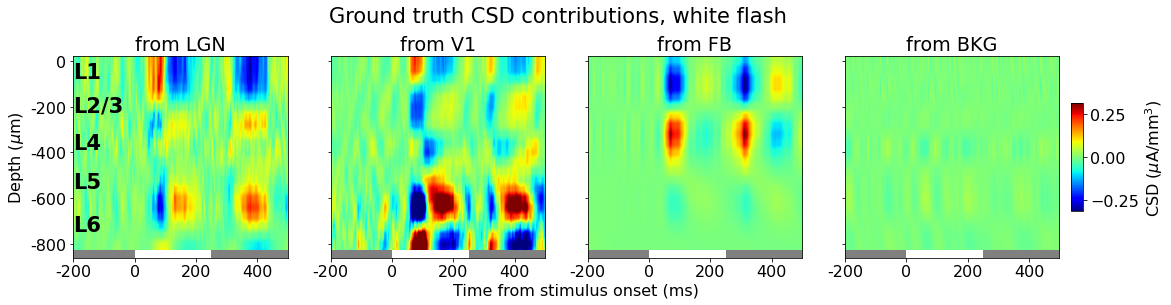

In [138]:
nchan_lim = 22

corr_pops_pen_dict = dict()
rel_MSE_pops_pen_dict = dict()

csd_lpa_pen_dict = dict()

istim = 0

#if pen_fac == pen_facs[-1]:
fig, axes = plt.subplots(nrows = 1, ncols = npop_guess+3, figsize = (5.5*(npop_guess+2),4.3), sharex = True, sharey = True)

tstim_onset = 200
scale_to_uA = 1E-3

rel_MSE_pops = dict()
corr_pops = dict()

csd_sims_gt_v1_summed = csd_gt_flashes[flash_types[istim]]

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim]*scale_to_uA #tstim_onset:tstim_onset+101]

    #if 'LGN' not in sim_name:
    #    csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))

    icol = isim % 4

    ax = axes[icol]

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range = np.abs(csd_sim).max()

    ax.imshow(csd_sim, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

    ax.set_title('from '+sim_name)

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    if istim == 0:
        ax.hlines(y = 21.1, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = 21.1, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
        ax.hlines(y = 21.1, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
    elif istim == 1:
        ax.hlines(y = 21.1, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = 21.1, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
        ax.hlines(y = 21.1, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')


corr_pops_pen_dict[pen_fac] = corr_pops
rel_MSE_pops_pen_dict[pen_fac] = rel_MSE_pops

ax.set_xticks(np.arange(0,csd_sim.shape[1],200))
ax.set_xticklabels(np.arange(0,csd_sim.shape[1],200)-200)

plt.figtext(s = 'Ground truth CSD contributions, '+flash_types[istim]+' flash', x = 0.285, y = 0.91, fontsize = 21)
plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.03)

cbaxes = fig.add_axes([0.91,0.3,0.01, 0.35])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

ax.set_xlim([0, csd_sim.shape[1]-1])

for i in range(1,2):
    plt.figtext(x = 0.07, y = 1.13-i*0.4, s = 'L1', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 1.02-i*0.4, s = 'L2/3', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.9-i*0.4, s = 'L4', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.775-i*0.4, s = 'L5', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.635-i*0.4, s = 'L6', fontsize = 21, fontweight = 560)

fig.subplots_adjust(left = 0.07, right = 0.9, bottom = 0.15, top = 0.8)

#fig_name = 'csd_LPA_est_pop_contribs_white_flash_'+config_name+'_w_rel_MSE_lamda'+str(np.round(pen_fac, 4))+'.png'

fig_name = 'csd_ground_truth_est_pop_contribs_'+flash_types[istim]+'_flash.png'

if istim == 0:
    savepath = os.path.join(fig_dir, 'pop_est', flash_types[istim])
else:
    savepath = os.path.join(fig_dir.rsplit('/', 1)[0], 'Supplementary_figures', 'pop_est', flash_types[istim])

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#if pen_fac == pen_facs[-1]:
#fig.savefig(savepath, facecolor = 'w') 

### Get and plot LPA-estimated population CSD

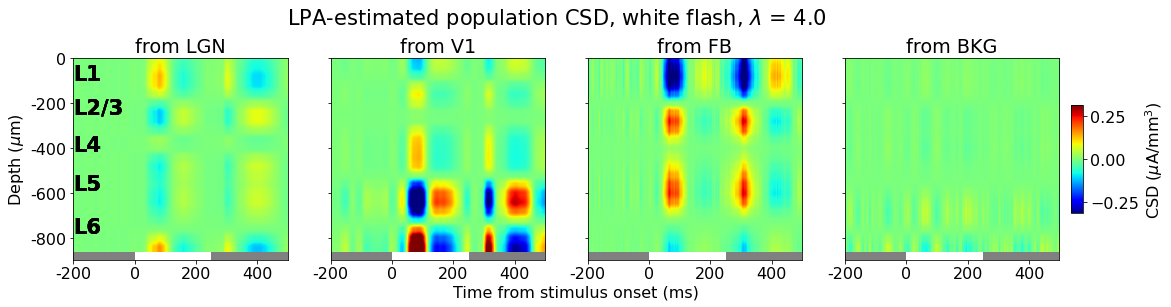

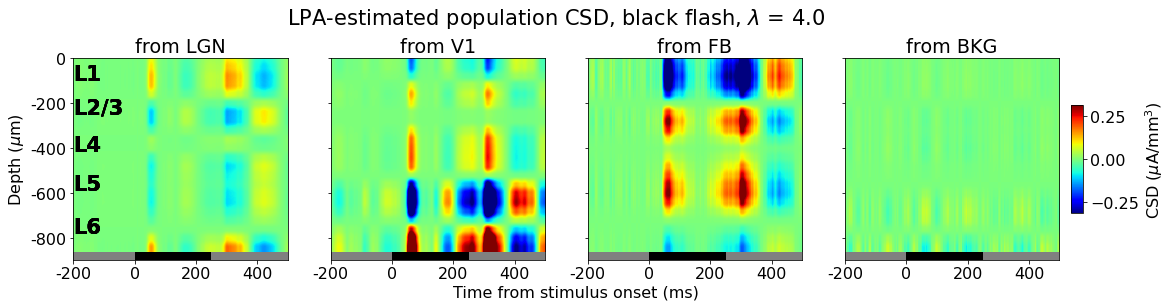

In [139]:
nchan_lim = 22

corr_pops_flashes = dict()
rel_MSE_pops_flashes = dict()

for istim in range(2):
    corr_pops_pen_dict = dict()
    rel_MSE_pops_pen_dict = dict()

    csd_lpa_pen_dict = dict()
    for pen_fac in list(Rmat.keys()):
        Rmat_lpa = Rmat[pen_fac]
        Cmat_lpa = Cmat[pen_fac]

        csd_lpa_pop_recon = np.zeros((Rmat_lpa.shape[0], Rmat_lpa.shape[2], Cmat_lpa.shape[0], Rmat_lpa.shape[1]))

        csd_lpa_dict = dict()
        for iflash, sim_name in enumerate(csd_sims.keys()):
            csd_lpa_pops_dict = dict()
            for ipop in range(Cmat_lpa.shape[-1]):

                csd_lpa_pop_recon[iflash, ipop] = np.outer(Cmat_lpa[:,ipop], Rmat_lpa[iflash,:,ipop])

                pop_name = pop_names[ipop % (npop_guess+3)]

                csd_lpa_pops_dict[pop_name] = csd_lpa_pop_recon[iflash,ipop]

            csd_lpa_dict[sim_name] = csd_lpa_pops_dict

        csd_lpa_pen_dict[pen_fac] = csd_lpa_dict

        #if pen_fac == pen_facs[-1]:
        if pen_fac == optimal_pen_fac:
            fig, axes = plt.subplots(nrows = 1, ncols = npop_guess+3, figsize = (5.5*(npop_guess+2),4.3), sharex = True, sharey = True)

        tstim_onset = 200
        scale_to_uA = 1E-3

        rel_MSE_pops = dict()
        corr_pops = dict()
        
        csd_sims_gt_v1_summed = csd_gt_flashes[flash_types[istim]]
        for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
            csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim]*scale_to_uA #tstim_onset:tstim_onset+101]

            #if 'LGN' not in sim_name:
            #    csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))

            csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :]*scale_to_uA #, tstim_onset:tstim_onset+101]

            diff_csd = csd_sim - csd_lpa_pop_est

            rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()

            rel_MSE_pops[sim_name] = rel_MSE


            corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
            corr_pops[sim_name] = corr

            #if pen_fac == pen_facs[-1]:

            icol = isim % 4

            if pen_fac == optimal_pen_fac:
                ax = axes[icol]

            if pen_fac == optimal_pen_fac:
                if icol == 0:
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(ytick_labels)
                    ax.set_ylabel('Depth ($\mu$m)')

                if isim == 0:
                    cmap_range = np.abs(csd_sim).max()

                #csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA

                ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

                ax.set_title('from '+sim_name)

                if icol == 0:
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(ytick_labels)
                    ax.set_ylabel('Depth ($\mu$m)')
                    
                                
                if istim == 0:
                    ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
                    ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
                    ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
                elif istim == 1:
                    ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
                    ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
                    ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
                    
                ax.set_ylim([22.4, 0])
                
                for i in range(1,2):
                    plt.figtext(x = 0.07, y = 1.13-i*0.4, s = 'L1', fontsize = 21, fontweight = 560)
                    plt.figtext(x = 0.07, y = 1.02-i*0.4, s = 'L2/3', fontsize = 21, fontweight = 560)
                    plt.figtext(x = 0.07, y = 0.9-i*0.4, s = 'L4', fontsize = 21, fontweight = 560)
                    plt.figtext(x = 0.07, y = 0.775-i*0.4, s = 'L5', fontsize = 21, fontweight = 560)
                    plt.figtext(x = 0.07, y = 0.635-i*0.4, s = 'L6', fontsize = 21, fontweight = 560)

                #if icol == 1:
                #    ax.set_xlabel('Time from stimulus onset (ms)')


                #ax.set_title('Rel. MSE = '+str(np.round(rel_MSE,2))+',\ncorr. = '+str(np.round(corr,2)))

                #ax.set_xticks(xticks)
                #ax.set_xticklabels(xticks_labels)

        corr_pops_pen_dict[pen_fac] = corr_pops
        rel_MSE_pops_pen_dict[pen_fac] = rel_MSE_pops
        
        if pen_fac == optimal_pen_fac:
            ax.set_xticks(np.arange(0,csd_lpa_pop_est.shape[1],200))
            ax.set_xticklabels(np.arange(0,csd_lpa_pop_est.shape[1],200)-200)


        '''if pen_fac < 1E-3:
            plt.figtext(s = 'First 100 ms of evoked response', x = 0.27, y = 0.9, fontsize = 22)
        else:
            plt.figtext(s = 'First 100 ms of evoked response, $\lambda$ = '+str(np.round(pen_fac, 4)), x = 0.27, y = 0.9, fontsize = 22)'''

        #plt.figtext(s='Ground truth CSD contributions', x = 0.37, y = 0.85, fontsize = 21)
        
        if pen_fac == optimal_pen_fac:
            plt.figtext(s = 'LPA-estimated population CSD, '+flash_types[istim]+' flash, $\lambda$ = '+str(np.round(pen_fac,1)), \
                        x = 0.25, y = 0.91, fontsize = 21)

            plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.03)

            #plt.figtext(s = 'Difference between ground truth and estimate', x = 0.27, y = 0.37, fontsize = 18)

            cbaxes = fig.add_axes([0.91,0.3,0.01, 0.35])
            cb = fig.colorbar(im, ax = ax, cax = cbaxes)
            cb.set_label('CSD ($\mu$A/mm$^3$)')

            ax.set_xlim([0, csd_sim.shape[1]-1])

            fig.subplots_adjust(left = 0.07, right = 0.9, bottom = 0.15, top = 0.8)

            #fig_name = 'csd_LPA_est_pop_contribs_'+flash_types[istim]+'_flash_lamda'+str(np.round(pen_fac, 4))+'_w_lpa_est_fir_rates.png'
            
            fig_name = 'csd_LPA_est_pop_contribs_'+flash_types[istim]+'_flash_lamda'+str(np.round(pen_fac, 4))+'_w_lpa_est_fir_rates.png'

            if istim == 0:
                savepath = os.path.join(fig_dir, 'pop_est', flash_types[istim])
            else:
                savepath = os.path.join(fig_dir, 'Supplementary_figures', 'pop-est', flash_types[istim])

            if not os.path.exists(savepath):
                if not os.path.exists(savepath.rsplit('/', 1)[0]):
                    os.mkdir(savepath.rsplit('/', 1)[0])
                    os.mkdir(savepath)
                else:
                    os.mkdir(savepath)

                if not os.path.exists(savepath):
                    os.mkdir(savepath)

            savepath = os.path.join(savepath, fig_name)

            #if pen_fac == pen_facs[-1]:
            #fig.savefig(savepath, facecolor = 'w')

    corr_pops_flashes[flash_types[istim]] = corr_pops_pen_dict
    rel_MSE_pops_flashes[flash_types[istim]] = rel_MSE_pops_pen_dict

## Quantify similarity of LPA-estimated population CSD to ground truth CSD

In [140]:
do_plot = False

corr_pops_flash_types = dict()
rel_MSE_pops_flash_types = dict()

for istim in range(2):
    flash_type = flash_types[istim]
    
    corr_pops_pen_dict = dict()
    rel_MSE_pops_pen_dict = dict()
    
    csd_lpa_pen_dict = dict()
    for pen_fac in list(Rmat.keys()):
        Rmat_lpa = Rmat[pen_fac]
        Cmat_lpa = Cmat[pen_fac]

        csd_lpa_pop_recon = np.zeros((Rmat_lpa.shape[0], Rmat_lpa.shape[2], Cmat_lpa.shape[0], Rmat_lpa.shape[1]))


        csd_lpa_dict = dict()
        for iflash, sim_name in enumerate(csd_sims.keys()):
            csd_lpa_pops_dict = dict()
            for ipop in range(Cmat_lpa.shape[-1]):

                csd_lpa_pop_recon[iflash, ipop] = np.outer(Cmat_lpa[:,ipop], Rmat_lpa[iflash,:,ipop])

                pop_name = pop_names[ipop % (npop_guess+3)]

                csd_lpa_pops_dict[pop_name] = csd_lpa_pop_recon[iflash,ipop]

            csd_lpa_dict[sim_name] = csd_lpa_pops_dict

        csd_lpa_pen_dict[pen_fac] = csd_lpa_dict


        #if pen_fac == pen_facs[-1]:
        if do_plot:
            fig, axes = plt.subplots(nrows = 2, ncols = npop_guess+3, figsize = (6*(npop_guess+2),10), sharex = True, sharey = True)

            fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

        tstim_onset = 200
        scale_to_uA = 1E-3

        rel_MSE_pops = dict()
        corr_pops = dict()
        
        csd_sims_gt_v1_summed = csd_gt_flashes[flash_types[istim]]

        for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
            csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim]*scale_to_uA #tstim_onset:tstim_onset+101]

            #if 'LGN' not in sim_name:
            #    csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))

            csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :]*scale_to_uA #, tstim_onset:tstim_onset+101]

            diff_csd = csd_sim - csd_lpa_pop_est

            rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()

            rel_MSE_pops[sim_name] = rel_MSE


            corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
            corr_pops[sim_name] = corr

            #if pen_fac == pen_facs[-1]:

            icol = isim % 4
            
            if do_plot:
                ax = axes[0, icol]

                if icol == 0:
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(ytick_labels)
                    ax.set_ylabel('Depth ($\mu$m)')

                if isim == 0:
                    cmap_range = np.abs(csd_sim).max()

                im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')

                ax.set_title('from '+sim_name)

                #csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA

                ax = axes[1, icol]

                if icol == 0:
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(ytick_labels)
                    ax.set_ylabel('Depth ($\mu$m)')

                ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

                ax.set_title('from '+sim_name)

                if icol == 0:
                    ax.set_yticks(yticks)
                    ax.set_yticklabels(ytick_labels)
                    ax.set_ylabel('Depth ($\mu$m)')

        corr_pops_pen_dict[pen_fac] = corr_pops
        rel_MSE_pops_pen_dict[pen_fac] = rel_MSE_pops

        #if pen_fac == pen_facs[-1]:
        if do_plot:
            ax.set_xticks(np.arange(0,csd_lpa_pop_est.shape[1],200))
            ax.set_xticklabels(np.arange(0,csd_lpa_pop_est.shape[1],200)-200)


        if do_plot:
            plt.figtext(s='Ground truth CSD contributions', x = 0.37, y = 0.85, fontsize = 21)

            plt.figtext(s = 'LPA estimated CSD contributions, $\lambda = $'+str(pen_fac), x = 0.37, y = 0.48, fontsize = 21)

            plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.11)

            cbaxes = fig.add_axes([0.89,0.38,0.01, 0.2])
            cb = fig.colorbar(im, ax = ax, cax = cbaxes)
            cb.set_label('CSD ($\mu$A/mm$^3$)')

            ax.set_xlim([0, csd_sim.shape[1]-1])

            cb.set_label('CSD ($\mu$A/mm$^3$)')

            for i in range(2):
                plt.figtext(x = 0.1, y = 0.77-i*0.37, s = 'L1', fontsize = 21, fontweight = 560)
                plt.figtext(x = 0.1, y = 0.725-i*0.37, s = 'L2/3', fontsize = 21, fontweight = 560)
                plt.figtext(x = 0.1, y = 0.675-i*0.37, s = 'L4', fontsize = 21, fontweight = 560)
                plt.figtext(x = 0.1, y = 0.63-i*0.37, s = 'L5', fontsize = 21, fontweight = 560)
                plt.figtext(x = 0.1, y = 0.575-i*0.37, s = 'L6', fontsize = 21, fontweight = 560)

            fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_rel_MSE_w_bkg_lamda'+str(np.round(pen_fac, 4))+'.png'

            savepath = os.path.join(fig_dir, 'pop_est')

            if not os.path.exists(savepath):
                os.mkdir(savepath)

            savepath = os.path.join(savepath, fig_name)

            #if pen_fac == pen_facs[-1]:
            #fig.savefig(savepath, facecolor = 'w')
        
    corr_pops_flash_types[flash_type] = corr_pops_pen_dict
    rel_MSE_pops_flash_types[flash_type] = rel_MSE_pops_pen_dict

#### Rearrange dictionaries with metrics for different penalty values

In [141]:
corr_pops_flashes_rearr = dict()
rel_MSE_pops_flashes_rearr = dict()

for istim in range(2):
    rel_MSE_pops_pen_dict = rel_MSE_pops_flash_types[flash_types[istim]]
    corr_pops_pen_dict = corr_pops_flash_types[flash_types[istim]]

    corr_pops_pen_rearr = dict()
    rel_MSE_pops_pen_rearr = dict()
    for ipop, pop_name in enumerate(corr_pops_pen_dict[pen_fac].keys()):
        corr_pops_temp = []
        rel_MSE_pops_temp = []
        for ipen, pen_fac in enumerate(corr_pops_pen_dict.keys()):

            corr_pops_temp.append(corr_pops_pen_dict[pen_fac][pop_name])
            rel_MSE_pops_temp.append(rel_MSE_pops_pen_dict[pen_fac][pop_name])

        corr_pops_pen_rearr[pop_name] = corr_pops_temp
        rel_MSE_pops_pen_rearr[pop_name] = rel_MSE_pops_temp
        
    rel_MSE_pops_flashes_rearr[flash_types[istim]] = rel_MSE_pops_pen_rearr
    corr_pops_flashes_rearr[flash_types[istim]] = corr_pops_pen_rearr

### Plot metrics for different penalty values

#### Correlation

Figures/test_notebooks/pop_est/ corr_dependence_on_penalty_term_white_w_mod_fir_rates.png
Figures/test_notebooks/Supplementary_figures/pop-est/black/ corr_dependence_on_penalty_term_black_w_mod_fir_rates.png


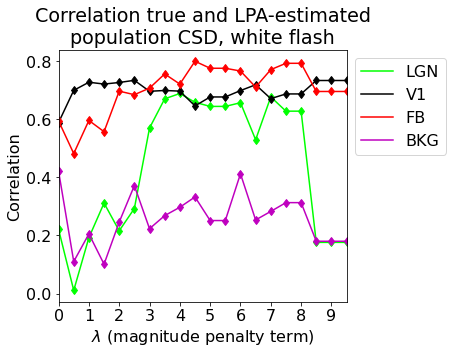

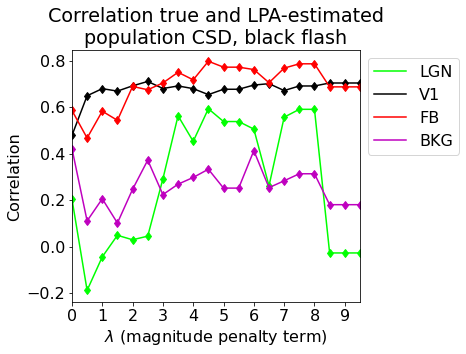

In [142]:
colors = ['lime', 'black', 'r', 'm']

for istim, flash_type in enumerate(corr_pops_flashes_rearr.keys()):
    corr_pops_pen_rearr= corr_pops_flashes_rearr[flash_type]

    fig, ax = plt.subplots(ncols = 1, figsize = (8,5))

    for ipop, pop_name in enumerate(corr_pops_pen_rearr.keys()):
        ax.plot(pen_facs, corr_pops_pen_rearr[pop_name], color = colors[ipop], label = pop_name)
        ax.plot(pen_facs, corr_pops_pen_rearr[pop_name], 'd', color = colors[ipop])

    ax.set_xlabel('$\lambda$ (magnitude penalty term)')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation true and LPA-estimated\npopulation CSD, '+flash_types[istim]+' flash')

    ax.legend(bbox_to_anchor = (1,1))

    ax.margins(x=0)

    ax.set_xticks(np.arange(0,10,1))
    ax.set_xticks(np.arange(0,10,1))

    fig.subplots_adjust(left = 0.2, right = 0.7, bottom = 0.15, top = 0.85)

    fig_name = ' corr_dependence_on_penalty_term_'+flash_types[istim]+'_w_mod_fir_rates.png'
    
    #fig_name = 'corr_dependence_on_penalty_term_'+flash_types[istim]+'_w_lpa_est_fir_rates.png'
    
    #fig_name = 'corr_dependence_on_penalty_term_'+flash_types[istim]+'_w_lpa_est_fir_rates_w_rescale.png'

    if istim == 0:
        savepath = os.path.join(fig_dir, 'pop_est')
    else:
        savepath = os.path.join(fig_dir, 'Supplementary_figures', 'pop-est', flash_types[istim])

    if not os.path.exists(savepath):
        if not os.path.exists(savepath.rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0])
            os.mkdir(savepath)
        else:
            os.mkdir(savepath)

        if not os.path.exists(savepath):
            os.mkdir(savepath)

    savepath = os.path.join(savepath, fig_name)
    
    print(savepath)

    #fig.savefig(savepath, facecolor = 'w')

#### Relative MSE

Figures/test_notebooks/pop_est


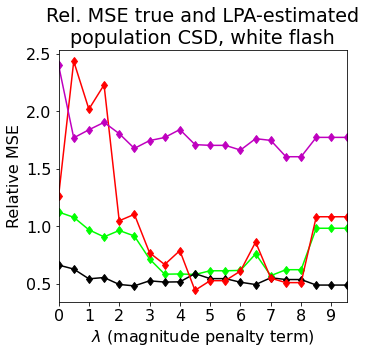

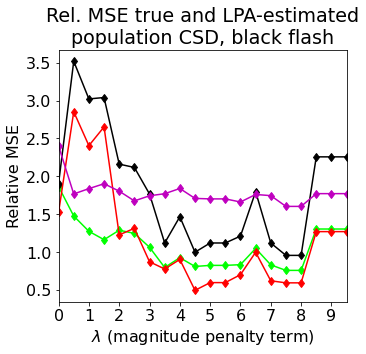

In [143]:
for istim, flash_type in enumerate(rel_MSE_pops_flashes_rearr.keys()):
    rel_MSE_pops_pen_rearr = rel_MSE_pops_flashes_rearr[flash_type]

    fig, ax = plt.subplots(ncols = 1, figsize = (8,5))

    for ipop, pop_name in enumerate(rel_MSE_pops_pen_rearr.keys()):
        ax.plot(pen_facs, rel_MSE_pops_pen_rearr[pop_name], color = colors[ipop], label = pop_name)
        ax.plot(pen_facs, rel_MSE_pops_pen_rearr[pop_name], 'd', color = colors[ipop])

    ax.set_xlabel('$\lambda$ (magnitude penalty term)')
    ax.set_ylabel('Relative MSE')
    ax.set_title('Rel. MSE true and LPA-estimated\npopulation CSD, '+flash_types[istim]+' flash')

    #ax.legend(bbox_to_anchor = (1,1))

    ax.margins(x=0)

    ax.set_xticks(np.arange(0,10,1))
    ax.set_xticks(np.arange(0,10,1))

    fig.subplots_adjust(left = 0.2, right = 0.7, bottom = 0.15, top = 0.85)

    #fig_name = ' rel_MSE_dependence_on_penalty_term.png'
    
    fig_name = ' rel_MSE_dependence_on_penalty_term_w_mod_fir_rates.png'
    
    #fig_name = ' rel_MSE_dependence_on_penalty_term_w_lpa_est_fir_rates.png'
    
    #fig_name = ' rel_MSE_dependence_on_penalty_term_w_lpa_est_fir_rates_w_rescale.png'

    if istim == 0:
        savepath = os.path.join(fig_dir, 'pop_est')
        print(savepath)
    else:
        savepath = os.path.join(fig_dir, 'Supplementary_figures', 'pop-est', flash_types[istim])

    if not os.path.exists(savepath):
        if not os.path.exists(savepath.rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0])
            os.mkdir(savepath)
        else:
            os.mkdir(savepath)

        if not os.path.exists(savepath):
            os.mkdir(savepath)

    savepath = os.path.join(savepath, fig_name)

    #fig.savefig(savepath, facecolor = 'w')

#### Show metrics in tables

In [144]:
import pandas as pd
from IPython.display import display

for istim, flash_type in enumerate(corr_pops_flash_types.keys()):
    
    corr_pops_pen_dict = corr_pops_flash_types[flash_type]
    rel_MSE_pops_pen_dict = rel_MSE_pops_flash_types[flash_type]

    for pen_fac in corr_pops_pen_dict.keys():
        corr_pops = corr_pops_pen_dict[pen_fac]
        rel_MSE_pops = rel_MSE_pops_pen_dict[pen_fac]

        pd.set_option('precision', 2)
        # intialise data of lists.
        data = {'': ['LGN', 'V1', 'FB', 'BKG'],
                "Relative MSE": [str(np.round(rel_MSE_pops['LGN'],1)), 
                                str(np.round(rel_MSE_pops['V1'],1)),
                                str(np.round(rel_MSE_pops['FB'],1)),
                                str(np.round(rel_MSE_pops['BKG'],1))],
                'Correlation': [corr_pops['LGN'], corr_pops['V1'], corr_pops['FB'], corr_pops['BKG']]}

        # Create DataFrame
        df = pd.DataFrame(data)

        caption = 'Title'

        styles = [dict(selector="caption", 
            props=[("text-align", "center"),
            ("font-size", "120%"),
            ("color", 'black')])] 

        #df.style.set_table_attributes("style='display:inline; font-size:110%' ").set_caption(caption).set_table_styles(styles)._repr_html_()

        #df.style.set_caption("White flash")

        df.style.background_gradient()

        #display(HTML(df.to_html(formatters={'Relative MSE': '{:,.1f}'.format})))

        df = df.style.hide_index()

        print(flash_type, np.round(pen_fac,2))
        # Print the output.
        display(df)

white 0.0


,Relative MSE,Correlation
LGN,1.1,0.22
V1,0.7,0.59
FB,1.3,0.59
BKG,2.4,0.42


white 0.5


,Relative MSE,Correlation
LGN,1.1,0.01
V1,0.6,0.70
FB,2.4,0.48
BKG,1.8,0.11


white 1.0


,Relative MSE,Correlation
LGN,1.0,0.19
V1,0.5,0.73
FB,2.0,0.60
BKG,1.8,0.21


white 1.5


,Relative MSE,Correlation
LGN,0.9,0.31
V1,0.6,0.72
FB,2.2,0.56
BKG,1.9,0.10


white 2.0


,Relative MSE,Correlation
LGN,1.0,0.22
V1,0.5,0.73
FB,1.0,0.70
BKG,1.8,0.25


white 2.5


,Relative MSE,Correlation
LGN,0.9,0.29
V1,0.5,0.73
FB,1.1,0.68
BKG,1.7,0.37


white 3.0


,Relative MSE,Correlation
LGN,0.7,0.57
V1,0.5,0.70
FB,0.8,0.71
BKG,1.7,0.22


white 3.5


,Relative MSE,Correlation
LGN,0.6,0.67
V1,0.5,0.70
FB,0.7,0.76
BKG,1.8,0.27


white 4.0


,Relative MSE,Correlation
LGN,0.6,0.69
V1,0.5,0.70
FB,0.8,0.72
BKG,1.8,0.30


white 4.5


,Relative MSE,Correlation
LGN,0.6,0.66
V1,0.6,0.65
FB,0.4,0.80
BKG,1.7,0.33


white 5.0


,Relative MSE,Correlation
LGN,0.6,0.64
V1,0.5,0.68
FB,0.5,0.78
BKG,1.7,0.25


white 5.5


,Relative MSE,Correlation
LGN,0.6,0.64
V1,0.5,0.68
FB,0.5,0.78
BKG,1.7,0.25


white 6.0


,Relative MSE,Correlation
LGN,0.6,0.66
V1,0.5,0.70
FB,0.6,0.77
BKG,1.7,0.41


white 6.5


,Relative MSE,Correlation
LGN,0.8,0.53
V1,0.5,0.72
FB,0.9,0.71
BKG,1.8,0.25


white 7.0


,Relative MSE,Correlation
LGN,0.6,0.68
V1,0.6,0.67
FB,0.5,0.77
BKG,1.7,0.28


white 7.5


,Relative MSE,Correlation
LGN,0.6,0.63
V1,0.5,0.69
FB,0.5,0.79
BKG,1.6,0.31


white 8.0


,Relative MSE,Correlation
LGN,0.6,0.63
V1,0.5,0.69
FB,0.5,0.79
BKG,1.6,0.31


white 8.5


,Relative MSE,Correlation
LGN,1.0,0.18
V1,0.5,0.73
FB,1.1,0.70
BKG,1.8,0.18


white 9.0


,Relative MSE,Correlation
LGN,1.0,0.18
V1,0.5,0.73
FB,1.1,0.70
BKG,1.8,0.18


white 9.5


,Relative MSE,Correlation
LGN,1.0,0.18
V1,0.5,0.73
FB,1.1,0.70
BKG,1.8,0.18


black 0.0


,Relative MSE,Correlation
LGN,1.9,0.20
V1,1.9,0.48
FB,1.5,0.59
BKG,2.4,0.42


black 0.5


,Relative MSE,Correlation
LGN,1.5,-0.19
V1,3.5,0.65
FB,2.9,0.47
BKG,1.8,0.11


black 1.0


,Relative MSE,Correlation
LGN,1.3,-0.04
V1,3.0,0.68
FB,2.4,0.58
BKG,1.8,0.21


black 1.5


,Relative MSE,Correlation
LGN,1.2,0.05
V1,3.0,0.67
FB,2.7,0.54
BKG,1.9,0.10


black 2.0


,Relative MSE,Correlation
LGN,1.3,0.03
V1,2.2,0.69
FB,1.2,0.69
BKG,1.8,0.25


black 2.5


,Relative MSE,Correlation
LGN,1.2,0.04
V1,2.1,0.71
FB,1.3,0.67
BKG,1.7,0.37


black 3.0


,Relative MSE,Correlation
LGN,1.1,0.29
V1,1.8,0.68
FB,0.9,0.70
BKG,1.7,0.22


black 3.5


,Relative MSE,Correlation
LGN,0.8,0.56
V1,1.1,0.69
FB,0.8,0.75
BKG,1.8,0.27


black 4.0


,Relative MSE,Correlation
LGN,0.9,0.45
V1,1.5,0.68
FB,0.9,0.72
BKG,1.8,0.30


black 4.5


,Relative MSE,Correlation
LGN,0.8,0.59
V1,1.0,0.65
FB,0.5,0.80
BKG,1.7,0.33


black 5.0


,Relative MSE,Correlation
LGN,0.8,0.54
V1,1.1,0.68
FB,0.6,0.77
BKG,1.7,0.25


black 5.5


,Relative MSE,Correlation
LGN,0.8,0.54
V1,1.1,0.68
FB,0.6,0.77
BKG,1.7,0.25


black 6.0


,Relative MSE,Correlation
LGN,0.8,0.51
V1,1.2,0.69
FB,0.7,0.76
BKG,1.7,0.41


black 6.5


,Relative MSE,Correlation
LGN,1.0,0.26
V1,1.8,0.70
FB,1.0,0.70
BKG,1.8,0.25


black 7.0


,Relative MSE,Correlation
LGN,0.8,0.56
V1,1.1,0.67
FB,0.6,0.77
BKG,1.7,0.28


black 7.5


,Relative MSE,Correlation
LGN,0.8,0.59
V1,1.0,0.69
FB,0.6,0.79
BKG,1.6,0.31


black 8.0


,Relative MSE,Correlation
LGN,0.8,0.59
V1,1.0,0.69
FB,0.6,0.79
BKG,1.6,0.31


black 8.5


,Relative MSE,Correlation
LGN,1.3,-0.03
V1,2.3,0.70
FB,1.3,0.69
BKG,1.8,0.18


black 9.0


,Relative MSE,Correlation
LGN,1.3,-0.03
V1,2.3,0.70
FB,1.3,0.69
BKG,1.8,0.18


black 9.5


,Relative MSE,Correlation
LGN,1.3,-0.03
V1,2.3,0.70
FB,1.3,0.69
BKG,1.8,0.18


### Plot post-synaptic temporal profiles estimated with LPA

In [145]:
Rmat_lpa = Rmat[optimal_pen_fac]
Cmat_lpa = Cmat[optimal_pen_fac]

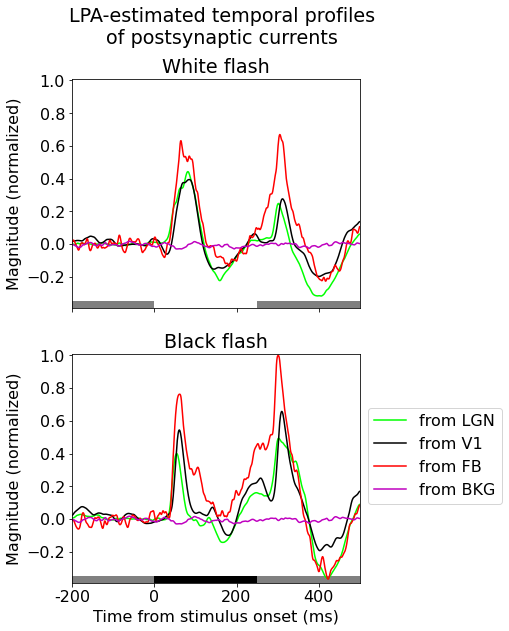

In [146]:
fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (8,5*2), sharex = True, sharey = True)

fig.subplots_adjust(left = 0.15, right = 0.65, bottom = 0.15, top = 0.85)

#t = np.arange(ntime)
#channel = np.arange(nchan)

pop_colors = ['b', 'g', 'darkorange', 'blueviolet']
pop_colors_w_lgn = ['lime', 'black', 'r', 'm']

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors
    
if Rmat_lpa.shape[-1] == 6:
    colors = ['lime', 'b', 'g', 'r', 'm', 'pink' ]
    pop_names = np.concatenate([pop_names, pop_names])
    
for istim in range(2):
    ax = axes[istim]
    for i in range(Rmat_lpa.shape[-1]):
        #if i > 2:
        #    continue
        fir_rate_lpa_plot = Rmat_lpa[istim,:,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
        if ~subtract_baseline:
            fir_rate_lpa_plot -= np.mean(fir_rate_lpa_plot[100:tstim_onset_sim], axis = 0)
        fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 2)/gaussian_filter(Rmat_lpa, sigma = (0,2,0)).max()
        ax.plot(fir_rate_lpa_plot, color = colors[i], label='from '+pop_names[i])
        #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
        if istim == 1:
            ax.set_xlabel('Time from stimulus onset (ms)')
        ax.set_ylabel('Magnitude (normalized)')
        #ax[1,0].set_ylabel('Magnitude (a. u.)')

        #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
        ax.set_title(flash_types[istim].capitalize()+' flash')

    ax.set_xticks(np.arange(0,fir_rate_lpa_plot.shape[0],200))
    ax.set_xticklabels(np.arange(0,fir_rate_lpa_plot.shape[0],200)-200)
    
    ypos_bar = -0.37
    if istim == 0:
        ax.hlines(y = ypos_bar, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = ypos_bar, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
        ax.hlines(y = ypos_bar, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
    elif istim == 1:
        ax.hlines(y = ypos_bar, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = ypos_bar, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
        ax.hlines(y = ypos_bar, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')

    ax.margins(x=0)
    
    ax.set_ylim([-0.39, 1.01])
    
fig.suptitle('LPA-estimated temporal profiles\nof postsynaptic currents', x = 0.41, y = 0.95
            )
    
ax.legend(bbox_to_anchor = (1,0.8))

#fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)


fig_name = 'LPA-est-both-flashes-postsyn-temporal-profile-lamda-'+str(pen_fac)+'-w-mod-fir-rates.png'

#fig_name = 'LPA-est-both-flashes-postsyn-temporal-profile-lamda-'+str(pen_fac)+'-w-LPA-est.png'

#fig_name = 'LPA-est-both-flashes-postsyn-temporal-profile-lamda-'+str(optimal_pen_fac)+'-w-LPA-est-w-rescale.png'

savepath = os.path.join(fig_dir, 'post_syn_temporal_profiles')
                        
if not os.path.exists(savepath):
        os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
                        
#fig.savefig(savepath, facecolor = 'w')

### LPA estimated spatial profiles of CSD

LGN -0.003604663339589642 15
V1 0.26266395005987575 5
FB 0.06852489643826842 5
LGN -0.00812971659341688 4


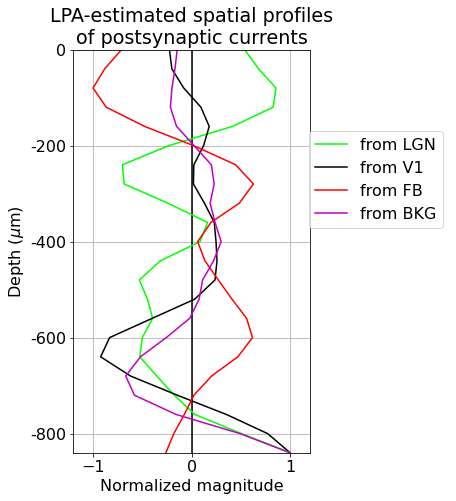

In [147]:
fig, ax = plt.subplots(figsize = (6.2,7))

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors
    
channel = np.arange(nchan_lim)

for ipop in range(Cmat_lpa.shape[-1]):
    spat_prof_lpa_pop = Cmat_lpa[:,ipop]
    spat_prof_lpa_pop_plot = spat_prof_lpa_pop/np.abs(spat_prof_lpa_pop).max()
    
    print(pop_names[ipop % (npop_guess+2)], spat_prof_lpa_pop_plot.sum(), abs(np.argmin(spat_prof_lpa_pop_plot)-np.argmax(spat_prof_lpa_pop_plot)))
    
    ax.plot(spat_prof_lpa_pop_plot, channel[:nchan_lim], color = pop_colors_w_lgn[ipop], label = 'from '+pop_names[ipop % (npop_guess+3)])#, color = colors[ipop % (npop_guess+2)])
    
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,20+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))

ax.vlines(x = 0, ymin = 0, ymax = nchan_lim)
ax.set_ylim([0,21])
ax.set_xlabel('Normalized magnitude')
    
ax.set_xlim([-1.2, 1.2])
ax.invert_yaxis()
ax.grid()
fig.legend(bbox_to_anchor = (1.01,0.75))

ax.set_title('LPA-estimated spatial profiles\nof postsynaptic currents')

fig.subplots_adjust(left = 0.15, right = 0.68, bottom = 0.1, top = 0.9)

fig_name = 'spatial_profile_LPA-est_CSD_pops_w_lpa-est_fir_rates.png'

fig_name = 'spatial_profile_LPA-est_CSD_pops_lamda-'+str(pen_fac)+'-w-mod-fir-rates.png'

savepath = os.path.join(fig_dir, 'post_syn_spatial_profiles')
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Total error as function of penalty

In [148]:
hitmonchan = ['#0f0f0f', '#ccb37a', '#a38a72', '#c4b3c4', '#59400f', '#bc3049', '#edd49b', '#a39ba3', '#614972', '#e56149', '#8a1f00', '#fe9359', '#fef5fe', '#ddccdd']
magneton = ['#383030', '#0f0f0f', '#8ab3a3', '#d4f5dd', '#514949', '#fefefe', '#8a8a8a', '#598261', '#b3d4bc', '#fe8a49', '#51ccf5', '#ed1700', '#2882ab', '#b3b3b3', '#d4d4d4']

In [149]:
csd_total_rel_MSE_rearr = dict()
csd_total_corr_rearr = dict()

for flash_type in ['white', 'black']:
    csd_rel_MSE_temp = []
    csd_corr_temp = []
    for pen_fac in csd_total_rel_MSE_pen.keys():
        csd_rel_MSE_temp.append(csd_total_rel_MSE_pen[pen_fac][flash_type])
        csd_corr_temp.append(csd_total_corr_pen[pen_fac][flash_type])
        
    csd_total_rel_MSE_rearr[flash_type] = csd_rel_MSE_temp
    csd_total_corr_rearr[flash_type] = csd_corr_temp

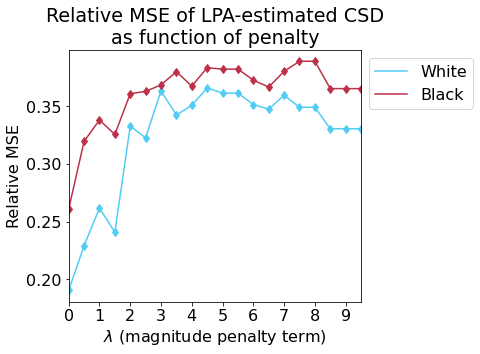

In [151]:
fig, ax = plt.subplots(figsize = (7,5))

colors = [magneton[10], hitmonchan[5]]

for istim, flash_type in enumerate(csd_total_rel_MSE_rearr.keys()):
    
    rel_MSE_pen_facs = csd_total_rel_MSE_rearr[flash_type]
    
    ax.plot(pen_facs, rel_MSE_pen_facs, label = flash_type.capitalize(), color = colors[istim])
    ax.plot(pen_facs, rel_MSE_pen_facs, 'd', color = colors[istim])
    
ax.set_xlabel('$\lambda$ (magnitude penalty term)')
ax.set_ylabel('Relative MSE')

ax.legend(bbox_to_anchor = (1,1))

ax.set_xticks(np.arange(0,10,1))
ax.set_xticks(np.arange(0,10,1))

#ax.set_ylim([0.24,0.26])

ax.margins(x=0)

ax.set_title('Relative MSE of LPA-estimated CSD\nas function of penalty')

fig.subplots_adjust(left = 0.16, right = 0.74, bottom = 0.15, top = 0.85)

fig_name = 'rel_MSE_dependence_on_penalty_term_both_flashes.png'

#fig_name = 'rel_MSE_dependence_on_penalty_term_'+kernel+'_both_flashes_w_lpa_est_fir_rates.png'

#fig_name = 'rel_MSE_dependence_on_penalty_term_'+kernel+'_both_flashes_w_lpa_est_fir_rates_w_rescale.png'

savepath = os.path.join(fig_dir, 'error')

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)
        
savepath = os.path.join(savepath, fig_name)
    
#fig.savefig(savepath, facecolor = 'w')

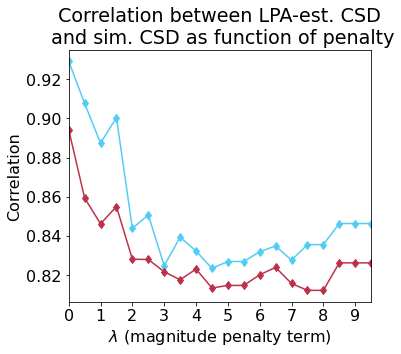

In [153]:
fig, ax = plt.subplots(figsize = (6,5))

#colors = [magneton[10], hitmonchan[5]]

for istim, flash_type in enumerate(csd_total_corr_rearr.keys()):
    
    corr_pen_facs = csd_total_corr_rearr[flash_type]
    
    ax.plot(pen_facs, corr_pen_facs, label = flash_type.capitalize(), color = colors[istim])
    ax.plot(pen_facs, corr_pen_facs, 'd', color = colors[istim])
    
ax.set_xlabel('$\lambda$ (magnitude penalty term)')
ax.set_ylabel('Correlation')

#ax.legend(bbox_to_anchor = (1,1))

ax.set_xticks(np.arange(0,10,1))
ax.set_xticks(np.arange(0,10,1))

#ax.set_ylim([0.24,0.26])

ax.margins(x=0)

ax.set_title('Correlation between LPA-est. CSD\n and sim. CSD as function of penalty')

fig.subplots_adjust(left = 0.2, right = 0.9, bottom = 0.15, top = 0.85)

fig_name = 'corr_dependence_on_penalty_term_both_flashes.png'

#fig_name = 'corr_dependence_on_penalty_term_'+kernel+'_both_flashes_w_lpa_est_fir_rates.png'

#fig_name = 'corr_dependence_on_penalty_term_'+kernel+'_both_flashes_w_lpa_est_fir_rates_w_rescale.png'

savepath = os.path.join(fig_dir, 'error')

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)
        
savepath = os.path.join(savepath, fig_name)
    
#fig.savefig(savepath, facecolor = 'w')